In [1]:
!pip install python-chess


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 4.1 MB/s eta 0:00:00


The **Model**

In [3]:
import torch
import torch.nn as nn

class StockwishEvalMLP(nn.Module):

    def __init__(self, num_features, num_units_hidden, num_classes=1):
        super().__init__()
        self.num_classes = num_classes
        self.num_units_hidden = num_units_hidden

        # the architecture is 3 hidden layers, each with 2048 units
        lin = nn.Linear(num_features, num_units_hidden)
        self.hidden_1 = nn.Sequential(
            lin,
            nn.BatchNorm1d(num_units_hidden),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
        )
        lin = nn.Linear(num_units_hidden, num_units_hidden)
        self.hidden_2 = nn.Sequential(
            lin,
            nn.BatchNorm1d(num_units_hidden),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
        )
        lin = nn.Linear(num_units_hidden, num_units_hidden)
        self.hidden_3 = nn.Sequential(
            lin,
            nn.BatchNorm1d(num_units_hidden),
            nn.ReLU(inplace=True),
            #nn.Dropout(0.2),
        )

        # added sigmoid hopefully makes the training better
        self.linear_out = nn.Sequential(
            torch.nn.Linear(num_units_hidden, num_classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden_1(x)
        x = self.hidden_2(x)
        x = self.hidden_3(x)
        return self.linear_out(x)


In [4]:
import torch
import chess
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from importlib import reload


# local imports
#from model import StockwishEvalMLP
from dataset import ChessDataset, Split
from utils import calculate_validation_loss_epoch, convert_to_cp



# Hyper parameters
LEARNING_RATE = 6e-2 # modified from 1e-3
MOMENTUM = 0.9 # modified from 0.7
NESTEROV = True
BATCH_SIZE = 1024 # modified from 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2
NUM_EPOCHS = 200
PIN_MEMORY = True
LOAD_MODEL = True
ROOT_DIR = "data"
MODEL_PATH = "drive/MyDrive/model_chess_4.pth"

# Model specific params
NUM_FEATURES = 8 * 8 * 12  # bitmap representation of chessboard is 8 x 8 x num_pieces = 8x8x12
NUM_HIDDEN = 2048  # from paper

# Globals
epoch_num = 0
losses = []
valid_losses = []

def visualize_results(model: StockwishEvalMLP, root_path, num_results):
    # need to set model to eval mode
    model.eval()
    # loading in val dataset with fens so that we can visualize results
    transform = lambda x: (torch.tensor(x)).float()
    val_ds = ChessDataset(root_path=root_path, transform=transform, split=Split.VALID, return_fen=True)
    print(val_ds.min)
    print(val_ds.max)

    for i in range(num_results):
        data, target, fen = val_ds[i]
        data = data.unsqueeze(0).to(device=DEVICE)
        #target = target.float().unsqueeze(1).to(device=DEVICE)
        print(data.size())
        pred = model(data).item()
        loss = (pred - target) ** 2
        cp_pred = convert_to_cp(pred, val_ds.min, val_ds.max)
        cp_target = convert_to_cp(target, val_ds.min, val_ds.max)
        board = chess.Board(fen)
        display(board)
        print(board)
        print(f"MSE Loss: {loss}, Predicted CP: {cp_pred}, Actual CP: {cp_target}")
    model.train()



def get_loaders(
        root_dir,
        batch_size,
        train_transform,
        target_transform,
        num_workers=4,
        pin_memory=True,
):

    train_ds = ChessDataset(root_path=root_dir, transform=train_transform, target_transform=target_transform, split=Split.TRAIN)

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = ChessDataset(root_path=root_dir, transform=train_transform, target_transform=target_transform, split=Split.VALID)

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )

    return train_loader, val_loader


"""
Does one epoch of training.
"""

def train(train_loader, val_loader, model, optimizer, loss_fn, scaler):
    global epoch_num
    global losses
    global valid_losses
    model.train()

    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):

        batch_losses = []
        data = data.squeeze(1).to(device=DEVICE) #[b_size, 768]
        #print(data)
        #print(data.size())
        targets = targets.float().unsqueeze(1).to(device=DEVICE) #[b_size, 1]
        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            batch_losses.append(loss)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_postfix(loss=loss.item())

    # once epoch is finished, we save state
    epoch_num += 1
    avg_epoch_loss =sum(batch_losses)/len(batch_losses)
    losses.append(avg_epoch_loss)
     # we should keep track of our validation losses as well
    loss = calculate_validation_loss_epoch(model, DEVICE, val_loader)
    valid_losses.append(loss)
    print(f"Epoch {epoch_num} completed. Avg. Training loss: {avg_epoch_loss} Avg. validation loss: {loss}. Model successfully saved!")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optim_state_dict': optimizer.state_dict(),
        'epoch': epoch_num,
        'loss_values': losses,
        'valid_losses': valid_losses,
    }, MODEL_PATH)




Load data into DataLoaders

In [5]:
global epoch_num
global losses
global valid_losses

train_transform = lambda x: (torch.tensor(x)).float()
target_transform = None
train_loader, val_loader = get_loaders(ROOT_DIR, BATCH_SIZE, train_transform, target_transform, NUM_WORKERS,
                                      PIN_MEMORY)


Start or continue training the **model**

In [18]:
loss_fn = nn.MSELoss()
model = StockwishEvalMLP(num_features=NUM_FEATURES, num_units_hidden=NUM_HIDDEN, num_classes=1).to(DEVICE)
# from paper 1
optimizer = optim.SGD(params=model.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=NESTEROV)
# from paper 2
#optimizer = optim.Adam(params=model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.99), eps=1e-8)
if LOAD_MODEL:
    # Loading a previous stored model from MODEL_PATH variable
    checkpoint = torch.load(MODEL_PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optim_state_dict'])
    epoch_num = checkpoint['epoch']
    losses = checkpoint['loss_values']
    valid_losses = checkpoint['valid_losses']
    print("Model successfully loaded!")

#visualize_results(model, ROOT_DIR, 10)

scaler = torch.cuda.amp.GradScaler()
for epoch in range(NUM_EPOCHS - epoch_num):
    train(train_loader, val_loader, model, optimizer, loss_fn, scaler)

Model successfully loaded!


100%|██████████| 489/489 [00:06<00:00, 80.82it/s]


Epoch 151 completed. Avg. Training loss: 0.0013500136556103826 Avg. validation loss: 0.007326753344386816. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 86.43it/s]


Epoch 152 completed. Avg. Training loss: 0.0008868650766089559 Avg. validation loss: 0.00734540494158864. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 85.81it/s]


Epoch 153 completed. Avg. Training loss: 0.001416316139511764 Avg. validation loss: 0.007407190278172493. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 85.31it/s]


Epoch 154 completed. Avg. Training loss: 0.0012186834355816245 Avg. validation loss: 0.007325636222958565. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.23it/s]


Epoch 155 completed. Avg. Training loss: 0.0016254967777058482 Avg. validation loss: 0.007376250345259905. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 82.71it/s]


Epoch 156 completed. Avg. Training loss: 0.0014330896083265543 Avg. validation loss: 0.007355840876698494. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.34it/s]


Epoch 157 completed. Avg. Training loss: 0.0011826506815850735 Avg. validation loss: 0.00734387943521142. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 81.82it/s]


Epoch 158 completed. Avg. Training loss: 0.0013212398625910282 Avg. validation loss: 0.007325358688831329. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 81.18it/s]


Epoch 159 completed. Avg. Training loss: 0.001536102732643485 Avg. validation loss: 0.007601580116897821. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.48it/s]


Epoch 160 completed. Avg. Training loss: 0.001250920700840652 Avg. validation loss: 0.007287176325917244. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 85.12it/s]


Epoch 161 completed. Avg. Training loss: 0.0014700919855386019 Avg. validation loss: 0.007353308144956827. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.14it/s]


Epoch 162 completed. Avg. Training loss: 0.0010747010819613934 Avg. validation loss: 0.007399136200547218. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.51it/s]


Epoch 163 completed. Avg. Training loss: 0.0018992832629010081 Avg. validation loss: 0.007415974047034979. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.48it/s]


Epoch 164 completed. Avg. Training loss: 0.0017399818170815706 Avg. validation loss: 0.007395594380795956. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 86.67it/s]


Epoch 165 completed. Avg. Training loss: 0.001263241982087493 Avg. validation loss: 0.007323778700083494. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 85.02it/s]


Epoch 166 completed. Avg. Training loss: 0.0012585098156705499 Avg. validation loss: 0.007318257819861174. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 81.26it/s]


Epoch 167 completed. Avg. Training loss: 0.0017401789082214236 Avg. validation loss: 0.007382621522992849. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.73it/s]


Epoch 168 completed. Avg. Training loss: 0.0015688056591898203 Avg. validation loss: 0.007365080993622541. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 80.64it/s]


Epoch 169 completed. Avg. Training loss: 0.0012427769834175706 Avg. validation loss: 0.0072501664981245995. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.22it/s]


Epoch 170 completed. Avg. Training loss: 0.001269642380066216 Avg. validation loss: 0.007401777431368828. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 86.83it/s]


Epoch 171 completed. Avg. Training loss: 0.00115284975618124 Avg. validation loss: 0.007264059502631426. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.62it/s]


Epoch 172 completed. Avg. Training loss: 0.001589659252204001 Avg. validation loss: 0.0073943911120295525. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 81.21it/s]


Epoch 173 completed. Avg. Training loss: 0.0013101898366585374 Avg. validation loss: 0.007284596096724272. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 81.08it/s]


Epoch 174 completed. Avg. Training loss: 0.0013192304177209735 Avg. validation loss: 0.0073434822261333466. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.64it/s]


Epoch 175 completed. Avg. Training loss: 0.001125102979131043 Avg. validation loss: 0.007266412489116192. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 82.71it/s]


Epoch 176 completed. Avg. Training loss: 0.0013554239412769675 Avg. validation loss: 0.00728654908016324. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.14it/s]


Epoch 177 completed. Avg. Training loss: 0.0011337695177644491 Avg. validation loss: 0.007301345467567444. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 82.18it/s]


Epoch 178 completed. Avg. Training loss: 0.001312701846472919 Avg. validation loss: 0.007459355518221855. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.61it/s]


Epoch 179 completed. Avg. Training loss: 0.0014500303659588099 Avg. validation loss: 0.00735305855050683. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.52it/s]


Epoch 180 completed. Avg. Training loss: 0.001121926004998386 Avg. validation loss: 0.007265912368893623. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 84.10it/s]


Epoch 181 completed. Avg. Training loss: 0.0015760668320581317 Avg. validation loss: 0.007342081051319838. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.89it/s]


Epoch 182 completed. Avg. Training loss: 0.0010609817691147327 Avg. validation loss: 0.007268979679793119. Model successfully saved!


100%|██████████| 489/489 [00:06<00:00, 80.09it/s]


Epoch 183 completed. Avg. Training loss: 0.0010222146520391107 Avg. validation loss: 0.007277105934917927. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.77it/s]


Epoch 184 completed. Avg. Training loss: 0.0013697438407689333 Avg. validation loss: 0.007419890724122524. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 83.96it/s]


Epoch 185 completed. Avg. Training loss: 0.0012518517905846238 Avg. validation loss: 0.0073082768358290195. Model successfully saved!


100%|██████████| 489/489 [00:05<00:00, 81.81it/s]


Epoch 186 completed. Avg. Training loss: 0.00105476682074368 Avg. validation loss: 0.007285519503057003. Model successfully saved!


  9%|▉         | 134/1465 [00:02<00:25, 52.97it/s, loss=0.0014]  


KeyboardInterrupt: 

In [9]:
#ROOT_PATH = "data"
#MODEL_PATH = "drive/MyDrive/model_chess.pth"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

transform = lambda x: (torch.tensor(x)).float()
val_ds = ChessDataset(root_path=ROOT_DIR, transform=transform, split=Split.VALID, return_fen=True)

drive/MyDrive/model_chess_4.pth
-1000.0
2000.0
torch.Size([1, 768])


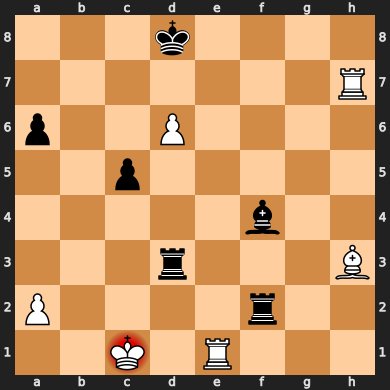

MSE Loss: 7.837446789843647e-05, Predicted CP: -53.70587110519409, Actual CP: -36.0
torch.Size([1, 768])


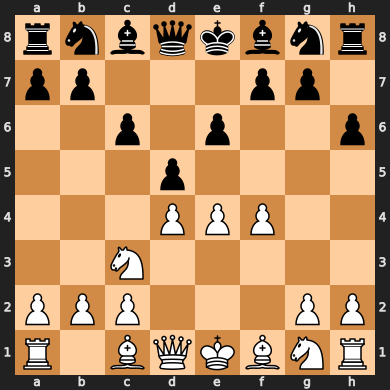

MSE Loss: 3.735460287580259e-05, Predicted CP: 52.22368240356445, Actual CP: 40.0
torch.Size([1, 768])


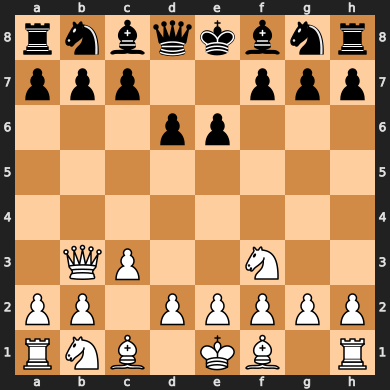

MSE Loss: 5.63123625415965e-05, Predicted CP: -21.008312702178955, Actual CP: -6.0
torch.Size([1, 768])


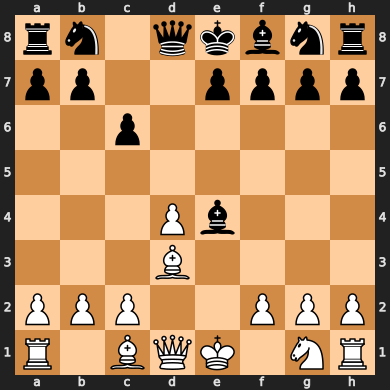

MSE Loss: 0.03925542448248446, Predicted CP: -366.2596344947815, Actual CP: 30.0
torch.Size([1, 768])


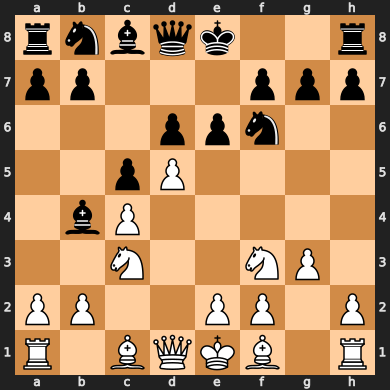

MSE Loss: 5.006781194231053e-05, Predicted CP: -29.84827756881714, Actual CP: -43.999999999999886
torch.Size([1, 768])


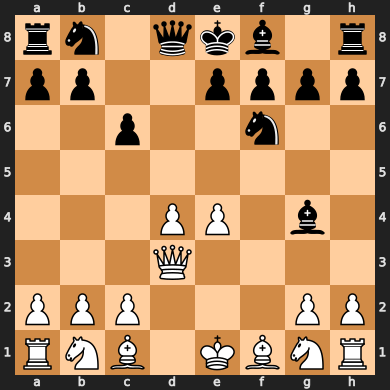

MSE Loss: 0.0002597941060003514, Predicted CP: 35.76374053955078, Actual CP: 68.0
torch.Size([1, 768])


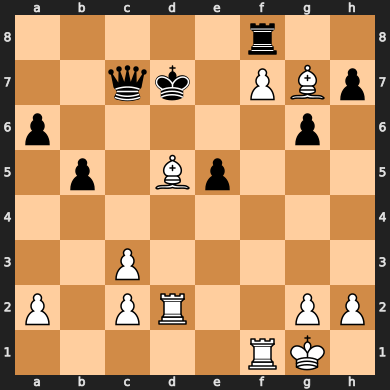

MSE Loss: 0.003213172406177023, Predicted CP: 886.6302967071533, Actual CP: 1000.0
torch.Size([1, 768])


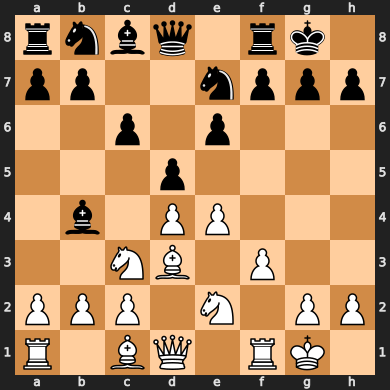

MSE Loss: 0.000284059247876576, Predicted CP: 13.708114624023438, Actual CP: -20.0
torch.Size([1, 768])


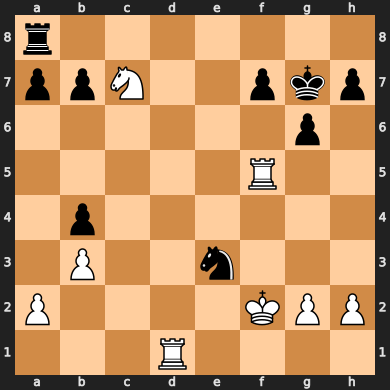

MSE Loss: 0.07928553262493052, Predicted CP: 96.15373611450195, Actual CP: -467.0
torch.Size([1, 768])


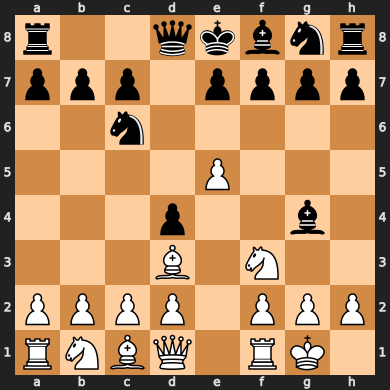

MSE Loss: 2.4352052488045885e-05, Predicted CP: -86.13044023513794, Actual CP: -96.0


In [19]:
ROOT_PATH = "data"
#MODEL_PATH = "drive/MyDrive/model_chess.pth"
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

def visualize_results(model: StockwishEvalMLP,root_path, num_results,val_ds=None):
    # need to set model to eval mode
    model.eval()
    # loading in val dataset with fens so that we can visualize results
    transform = lambda x: (torch.tensor(x)).float()
    # if val_ds is not passed in as parameter then we load the ds (this is slow)
    if val_ds is None:
        val_ds = ChessDataset(root_path=root_path, transform=transform, split=Split.VALID, return_fen=True)
    print(val_ds.min)
    print(val_ds.max)

    for i in range(num_results):
        data, target, fen = val_ds[i]
        data = data.to(device=DEVICE)
        print(data.size())
        #target = target.float().unsqueeze(1).to(device=DEVICE) #(256) -> (256, 1)
        pred = model(data).item()
        loss = (pred - target) ** 2
        cp_pred = convert_to_cp(pred, val_ds.min, val_ds.max)
        cp_target = convert_to_cp(target, val_ds.min, val_ds.max)
        board = chess.Board(fen)
        display(board)
        #print(board)
        print(f"MSE Loss: {loss}, Predicted CP: {cp_pred}, Actual CP: {cp_target}")
    model.train()
print(MODEL_PATH)
model = StockwishEvalMLP(num_features=NUM_FEATURES, num_units_hidden=NUM_HIDDEN, num_classes=1).to(DEVICE)
checkpoint = torch.load(MODEL_PATH)
model.load_state_dict(checkpoint['model_state_dict'])
visualize_results(model, ROOT_PATH, 10, val_ds)


Model successfully loaded!


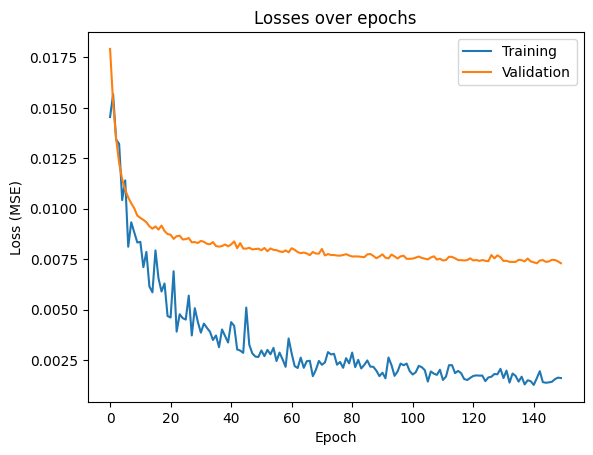

In [15]:
import matplotlib.pyplot as plt


def plot_loss_over_epochs(model_path):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    checkpoint = torch.load(model_path, map_location=device)
    epoch_num = checkpoint['epoch']
    losses = checkpoint['loss_values']
    val_losses = checkpoint['valid_losses']
    print("Model successfully loaded!")
    assert epoch_num == len(losses)
    losses_n = [loss.item() for loss in losses]
    val_n = [val.item() for val in val_losses]
    fig, ax = plt.subplots()
    ax.plot(range(len(losses_n)), losses_n)
    ax.plot(range(len(val_n)), val_n)
    ax.legend(['Training', 'Validation'])
    ax.set_title('Losses over epochs')
    ax.set_ylabel('Loss (MSE)')
    ax.set_xlabel('Epoch')
    plt.show()

plot_loss_over_epochs(MODEL_PATH)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import chess
import numpy as np

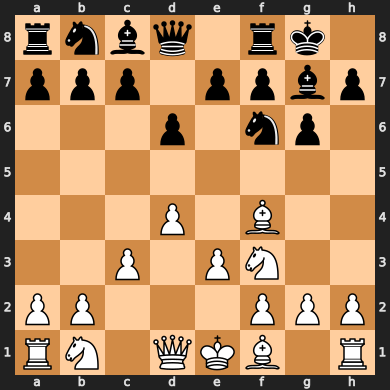

In [48]:
fen_string = "rnbq1rk1/ppp1ppbp/3p1np1/8/3P1B2/2P1PN2/PP3PPP/RN1QKB1R b KQ -"
board = chess.Board(fen_string)
board

In [49]:
def bitboards_to_array(bb: np.ndarray) -> np.ndarray:
    bb = np.asarray(bb, dtype=np.uint64)[:, np.newaxis]
    s = 8 * np.arange(7, -1, -1, dtype=np.uint64)
    b = (bb >> s).astype(np.uint8)
    b = np.unpackbits(b, bitorder="little")
    return b.reshape(-1, 8, 8)

def fen_to_array(fen_string):
  """
  Converts a FEN string to a 768-bit bitboard vector representation.

  Args:
      fen_string: The FEN string representing the chess position.

  Returns:
      A 12 x 8 x 8 numpy array representing the bitboard vector.
  """
  board = chess.Board(fen_string)

  black, white = board.occupied_co

  bitboards = np.array([
      black & board.pawns,
      black & board.knights,
      black & board.bishops,
      black & board.rooks,
      black & board.queens,
      black & board.kings,
      white & board.pawns,
      white & board.knights,
      white & board.bishops,
      white & board.rooks,
      white & board.queens,
      white & board.kings,
  ], dtype=np.uint64)

  board_array = bitboards_to_array(bitboards).astype('int8')

  if board.turn == chess.WHITE:
      # change all of the arrays of black pieces to -1
      for i in range(6):
          board_array[i] *= -1
  else:
      for i in range(6, 12):
        # change all of the arrays of white pieces to -1
          board_array[i] *= -1

  print(board_array.shape)
  return board_array

def array_to_vec(board_array):
  arr = board_array.reshape(1, 768)
  return arr



In [50]:
bb = fen_to_array(fen_string)
print(bb)

(12, 8, 8)
[[[ 0  0  0  0  0  0  0  0]
  [ 1  1  1  0  1  1  0  1]
  [ 0  0  0  1  0  0  1  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  1  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  1  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  0  1  0  0  0  0  0]
  [ 0  0  0  0  0  0  1  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 1  0  0  0  0  1  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]]

 [[ 0  0  0  1  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0]
 